In [1]:
import pandas as pd
import numpy as np
from typing import List
import glob
import os
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# 전처리 1차

In [ ]:
# 📁 원본 엑셀 파일들이 있는 폴더 경로
INPUT_DIR = 'data/01_Problem_Definition/'
# 📁 처리된 결과 파일을 저장할 폴더 경로
OUTPUT_DIR = 'data/02_Data_Preprocessing/df_1차_전처리_후'

In [ ]:
def process_performance_data(df: pd.DataFrame, output_filename: str):
    """
    Args:
        df (pd.DataFrame): 원본 공연 데이터프레임.
        output_filename (str): 결과를 저장할 Excel 파일 이름.
    """
    # 1. '공연 및 일시' 식별자 생성
    df['공연 및 일시'] = df['공연일시'].str[:10] + ' ' + df['공연코드']

    # 2. 관람객 수 계산을 위한 '실관람매수' 컬럼 생성
    df['실관람매수'] = np.where(df['예매/취소구분'] == 1, df['예매/취소매수'], -df['예매/취소매수'])

    # 3. 그룹별 집계를 위한 사용자 정의 함수 정의
    def aggregate_group(group: pd.DataFrame) -> pd.Series:
        # 그룹의 첫 번째 행에서 메타데이터 추출
        first_row = group.iloc[0]
        
        # 성비 계산
        male_count = (group['성별'] == 1).sum()
        female_count = (group['성별'] == 2).sum()
        total_gendered = male_count + female_count
        gender_ratio = round(male_count / total_gendered, 2) if total_gendered > 0 else 0
        
        # 집계 결과 반환
        return pd.Series({
            '관람객 수': group['실관람매수'].sum(),
            '성비': gender_ratio,

            '공연코드': first_row['공연코드'],
            '공연회차': first_row['공연회차'],
            '공연일시': first_row['공연일시'],
            '장르명': first_row['장르명'],
            '세부장르명': first_row['세부장르명'],
            '소요시간': first_row['소요시간'],
            '공연지역명': first_row['공연지역명'],
            '아동공연 여부': first_row['아동공연 여부'],
            '수상실적': first_row['수상실적'],

            '공연시설코드': first_row['공연시설코드'],
            '공연장코드': first_row['공연장코드'],
            '시설특성': first_row['시설특성'],
            '주소': first_row['주소'],
            '좌석수': first_row['좌석수'],
            
            '편의시설_레스토랑 여부': first_row['편의시설_레스토랑 여부'],
            '편의시설_카페 여부': first_row['편의시설_카페 여부'],
            '편의시설_편의점 여부': first_row['편의시설_편의점 여부'],
            '편의시설_놀이방 여부': first_row['편의시설_놀이방 여부'],
            '편의시설_수유실 여부': first_row['편의시설_수유실 여부'],

            '장애인시설_주차장 여부': first_row['장애인시설_주차장 여부'],
            '장애인시설_화장실 여부': first_row['장애인시설_화장실 여부'],
            '장애인시설_경사로 여부': first_row['장애인시설_경사로 여부'],
            '장애인시설_전용엘리베이터 여부': first_row['장애인시설_전용엘리베이터 여부'],

            '주차시설_자체 여부': first_row['주차시설_자체 여부'],
            '주차시설_공영 여부': first_row['주차시설_공영 여부'],
            
            '무대시설_오케스트라피트 여부': first_row['무대시설_오케스트라피트 여부'],
            '무대시설_연습실 여부': first_row['무대시설_연습실 여부'],
            '무대시설_분장실 여부': first_row['무대시설_분장실 여부'],
        })

    # 4. 전체 집계 연산 수행
    result_df = df.groupby('공연 및 일시').apply(aggregate_group)

    # 5. 결과를 파일로 저장
    result_df.to_excel(output_filename, index=True)

In [ ]:
# 원본 데이터는 공개하지 않음
# 실제 실행 시에는 INPUT_DIR 내의 원본 파일들을 사용하여 OUTPUT_DIR에 저장되도록 처리
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 예시: 지정 리스트 대신 폴더 내 일괄 처리 (원본이 없으면 건너뜀)
file_path_list = glob.glob(os.path.join(INPUT_DIR, '*.xlsx'))

if not file_path_list:
    print(f"경고: 원본 폴더 '{INPUT_DIR}' 에 처리할 엑셀 파일이 없습니다. 1차 전처리를 건너뜁니다.")
else:
    for file_path in file_path_list:
        try:
            df_kopis = pd.read_excel(file_path)
            output_name = os.path.join(OUTPUT_DIR, os.path.basename(file_path))
            process_performance_data(df_kopis, output_name)
        except FileNotFoundError:
            print(f"에러: '{file_path}' 파일을 찾을 수 없습니다.")
        except Exception as e:
            print(f"'{file_path}' 파일 처리 중 에러 발생: {e}")

# 전처리 2차

In [ ]:
# 1차 전처리를 마친 파일들이 있는 폴더
PROCESSED_DATA_DIR = 'data/02_Data_Preprocessing/df_1차_전처리_후'
# 최종 결과 파일을 저장할 폴더
FINAL_OUTPUT_DIR = 'data/02_Data_Preprocessing/df_2차_전처리_후'
FINAL_FILENAME = 'ml_df_raw.xlsx'

In [ ]:
def calculate_total_shows(raw_data_dir: str) -> pd.Series:
    """
    1차 전처리 후 데이터 폴더를 순회하며 공연코드별 총 공연 회차를 계산
    """
    
    # 지정된 폴더 내의 모든 엑셀 파일을 찾음
    raw_files = glob.glob(os.path.join(raw_data_dir, '*.xlsx'))
    if not raw_files:
        print(f"'{raw_data_dir}' 폴더에 원본 엑셀 파일이 없습니다.")
        return pd.Series(dtype='int64', name='총공연회차')

    all_show_counts = []
    for file_path in raw_files:
        try:
            df = pd.read_excel(file_path, usecols=['공연코드', '공연일시'])
            df.dropna(inplace=True)
            # 파일 내 공연코드별 고유한 공연일시 개수 계산
            show_counts = df.groupby('공연코드')['공연일시'].nunique()
            all_show_counts.append(show_counts)
        except Exception as e:
            print(f"- '{file_path}' 파일 처리 중 오류 발생: {e}")

    if not all_show_counts:
        print("처리할 수 있는 원본 파일이 없습니다.")
        return pd.Series(dtype='int64', name='총공연회차')
        
    # 모든 파일에서 계산된 회차 정보를 하나로 합침
    combined_counts = pd.concat(all_show_counts)
    
    # 여러 파일에 걸쳐 있는 동일 공연코드는 회차 수를 합산함
    final_counts = combined_counts.groupby('공연코드').sum()
    final_counts.name = '총공연회차'

    return final_counts

In [ ]:
def create_ml_dataframe(processed_data_dir: str, show_counts_series: pd.Series) -> pd.DataFrame:
    """
    1차 전처리된 데이터를 모두 합치고, 공연코드 기준으로 최종 집계
    """
    processed_files = glob.glob(os.path.join(processed_data_dir, '*.xlsx'))
    if not processed_files:
        print(f"'{processed_data_dir}' 폴더에 1차 처리된 파일이 없습니다.")
        return pd.DataFrame()

    # 1. 모든 1차 처리 데이터를 하나의 데이터프레임으로 결합
    df_list = [pd.read_excel(f, index_col=0) for f in processed_files]
    df_combined = pd.concat(df_list)
    
    # 2. 남자/여자 관객 수 계산
    df_combined['남자 수'] = (df_combined['성비'] * df_combined['관람객 수']).round()
    df_combined['여자 수'] = df_combined['관람객 수'] - df_combined['남자 수']

    # 3. 모든 집계 처리
    metadata_cols = {col: 'first' for col in df_combined.columns if col not in ['관람객 수', '성비', '남자 수', '여자 수']}
    agg_dict = {'남자 수': 'sum', '여자 수': 'sum', **metadata_cols}
    
    # '공연코드'가 인덱스에 있을 수 있으므로 컬럼으로 재설정
    if '공연코드' not in df_combined.columns:
        df_combined.reset_index(inplace=True)
        df_combined.rename(columns={'index': '공연코드'}, inplace=True)
        
    aggregated_df = df_combined.groupby('공연코드').agg(agg_dict)

    # 4. 집계 후 최종 값 계산 (벡터화)
    aggregated_df['총 관객 수'] = aggregated_df['남자 수'] + aggregated_df['여자 수']
    
    # 0으로 나누는 경우를 방지하며 최종 성비 계산
    aggregated_df['관람객 성비'] = np.where(
        aggregated_df['총 관객 수'] > 0,
        (aggregated_df['남자 수'] / aggregated_df['총 관객 수']).round(3),
        0
    )
    
    # 5. 시설 점수 계산 (벡터화)
    convenience_cols = ['편의시설_레스토랑 여부', '편의시설_카페 여부', '편의시설_편의점 여부', '편의시설_놀이방 여부', '편의시설_수유실 여부']
    obstacle_cols = ['장애인시설_주차장 여부', '장애인시설_화장실 여부', '장애인시설_경사로 여부', '장애인시설_전용엘리베이터 여부']
    aggregated_df['편의 시설 점수'] = aggregated_df[convenience_cols].eq('Y').sum(axis=1)
    aggregated_df['장애인 시설 점수'] = aggregated_df[obstacle_cols].eq('Y').sum(axis=1)
   
    # 6. 계산된 총 공연 회차 정보 결합
    aggregated_df = aggregated_df.merge(show_counts_series, left_index=True, right_index=True, how='left')
    aggregated_df['공연회차'] = aggregated_df['총공연회차']

    # 7. 최종 컬럼 정리
    final_columns = [
        '총 관객 수', '관람객 성비', '편의 시설 점수', '장애인 시설 점수',
        '공연회차', '소요시간', '장르명', '세부장르명', '아동공연 여부', '수상실적', 
        '공연시설코드', '공연장코드', '시설특성', '주소', '공연지역명', '좌석수',
        '주차시설_자체 여부', '주차시설_공영 여부',
        '무대시설_오케스트라피트 여부', '무대시설_연습실 여부', '무대시설_분장실 여부', 
        '관람연령', '무대시설_무대넓이'
        ]
    
    # 원본 데이터에 없는 컬럼이 있을 경우를 대비하여 예외 처리
    final_columns = [col for col in final_columns if col in aggregated_df.columns]
    
    final_df = aggregated_df[final_columns]
    
    return final_df

In [ ]:
# 1. 총 공연 회차 계산
show_counts = calculate_total_shows(PROCESSED_DATA_DIR)

# 2. 1차 처리된 데이터를 기반으로 최종 집계
final_df = create_ml_dataframe(PROCESSED_DATA_DIR, show_counts)

# 3. 결과 저장
if not final_df.empty:
    os.makedirs(FINAL_OUTPUT_DIR, exist_ok=True)
    output_path = os.path.join(FINAL_OUTPUT_DIR, FINAL_FILENAME)
    final_df.to_excel(output_path, index=True)

# 전처리 3차

In [ ]:
# 2차 전처리를 마친 파일들이 있는 폴더
ML_DF_RAW_PATH = 'data/02_Data_Preprocessing/df_2차_전처리_후/ml_df_raw.xlsx'

# hall_list_kopis 파일 경로
HALL_LIST_PATH = 'data/02_Data_Preprocessing/hall_list_kopis.xlsx'

# 최종 결과 파일을 저장할 폴더
OUTPUT_DIR = 'data/02_Data_Preprocessing/df_3차_전처리_후/'
FINAL_FILENAME = 'machine_learning_final.xlsx'

In [5]:
def clean_address_logic(address_series: pd.Series) -> pd.Series:
    """
    주소 시리즈를 입력받아 정제 로직을 적용 후 반환
    """
    # 1. 기본적인 전처리
    address = address_series.str.split('(').str[0].str.strip().fillna('')
    address = address.str.replace(r'\s*-\s*','-', regex=True)
    address = address.str.replace(r'(-\d+)\s.*', r'\1', regex=True)
    
    # 2. '종로구'/'구로구' 조건부 처리를 위한 마스크 생성
    is_jongro_guro = address.str.contains('종로구|구로구', na=False)
    contains_gil = address.str.contains('길', na=False)
    
    # 3. 순차적 정규식 적용 ('-로' 처리)
    pattern_ro_default = r'(.*로\s*\S*?\s*?[0-9-]+.*)'
    pattern_ro_jongro = r'(.*로\s*\S*(?:\s+\S+)?)'
    
    extracted_ro_default = address.str.extract(f"({pattern_ro_default})")[0]
    extracted_ro_jongro = address.str.extract(f"({pattern_ro_jongro})")[0]

    conditions = [is_jongro_guro & contains_gil, is_jongro_guro]
    choices = [address, extracted_ro_jongro]
    address_after_ro = pd.Series(
        np.select(conditions, choices, default=extracted_ro_default.values),
        index=address.index
    )
    address_after_ro = address_after_ro.fillna(address)

    # 4. 순차적 정규식 적용 ('-길' 처리)
    pattern_gil_default = r'(.*길\s*\S*?\s*?[0-9-]+.*)'
    pattern_gil_jongro = r'(.*길\s*\S*(?:\s+\S+)?)'

    extracted_gil_default = address_after_ro.str.extract(f"({pattern_gil_default})")[0]
    extracted_gil_jongro = address_after_ro.str.extract(f"({pattern_gil_jongro})")[0]
    
    cleaned_address = np.where(
        is_jongro_guro, extracted_gil_jongro, extracted_gil_default
    )
    
    # 5. 최종 정제 주소 반환 (매칭 안된 값은 이전 단계 값으로 보존)
    cleaned_series = pd.Series(cleaned_address, index=address_after_ro.index)
    return cleaned_series.fillna(address_after_ro)


In [ ]:
def process_kopis_data(input_path: str, output_path: str):
    """
    KOPIS 공연시설 DB 파일의 전체 전처리 과정을 수행
    """
    try:
        df = pd.read_excel(input_path, header=None)
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다.")
        return

    # 1. 초기 데이터 클리닝
    df.drop(index=[0, 1, 3], inplace=True)
    df.columns = df.iloc[0]
    df = df.iloc[1:].reset_index(drop=True)
    df.rename(columns={df.columns[9]: '구(군)'}, inplace=True)
    df.drop(columns=['No.'], inplace=True)

    # 2. 데이터 재구성 (행 분리)
    df['공연장명'] = df['공연장명'].str.split('\n')
    df['객석수'] = df['객석수'].str.split('\n')
    df = df.explode(['공연장명', '객석수']).reset_index(drop=True)
    
    # 3. 핵심 주소 정제 함수 호출
    df['address_cleaned'] = clean_address_logic(df['주소'])

    # 4. 주소 약어 표준화
    addr_mapping = {'전북': '전라북도', '충북': '충청북도', '부산부산광역시': '부산광역시', '서울': '서울특별시', '서울시': '서울특별시'}
    addr_parts = df['address_cleaned'].str.split(n=1, expand=True)
    addr_parts[0] = addr_parts[0].replace(addr_mapping)
    df['address_cleaned'] = addr_parts[0] + ' ' + addr_parts[1].fillna('')
    
    # 5. 파생 변수 생성 및 필터링
    df['시/도'] = df['address_cleaned'].str.split().str[0]
    df['구(군)'] = df['address_cleaned'].str.split().str[1] 
    df = df[~df['시/도'].isin(['-', '태국'])].copy()
    
    df['시설명'] = df['공연시설코드'] 
    df['공연장명']= df['공연장코드'] 
    
    if '좌석수' in df.columns:
        df['객석수'] = df['좌석수'] 

    # 6. 타입 변환
    df['객석수'] = pd.to_numeric(df['객석수'].astype(str).str.replace(',', ''), errors='coerce').fillna(0).astype(int)
    df['개관연도'] = pd.to_numeric(df['개관연도'], errors='coerce').fillna(0).astype(int)
    
    # 7. 불필요 컬럼 제거
    df.drop(columns=['주소'], inplace=True, errors='ignore')
    
    df.to_excel(output_path, index=False)


def process_culture_data(input_path: str, output_path: str):
    """
    한국문화정보원 DB 파일 전처리
    """
    try:
        df = pd.read_excel(input_path)
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다.")
        return

    # 1. 핵심 주소 정제 함수 호출 (입력 컬럼명만 다름)
    df['address_cleaned'] = clean_address_logic(df['도로명주소명'])
    final_col = ['시설명','address_cleaned','전화번호', '홈페이지주소','개관년도','시도명','시군구명']
    # 2. 최종 컬럼 선택 및 이름 변경
    final_cols_map = {
        '시설명': '공연시설명',
        '시도명':'시/도',
        '시군구명':'구(군)',
        '개관년도': '개관연도' 
    }
    # 파일에 없는 컬럼이 있을 수 있으므로, 존재하는 컬럼만 선택
    existing_cols = [col for col in final_col if col in df.columns]
    df = df[existing_cols]
    df.rename(columns=final_cols_map, inplace=True)

    df.to_excel(output_path, index=False)

In [20]:
def average_audience_per_show(df: pd.DataFrame) -> pd.DataFrame:
    """초기 피처('회차당 평균 관객 수') 생성"""
    avg_audience = np.divide(df['총 관객 수'], df['공연회차'], 
                             out=np.zeros_like(df['총 관객 수'], dtype=float), 
                             where=df['공연회차']!=0)
    df['회차당 평균 관객 수'] = avg_audience.astype(int)
    df.drop(columns=['총 관객 수'], inplace=True)
    return df

def correct_seat_counts(df: pd.DataFrame, hall_path: str) -> pd.DataFrame:
    """'수용가능인원'을 기준으로 '좌석수'를 보정"""
    
    try:
        hall_df = pd.read_excel(hall_path)[['공연시설코드', '수용가능인원']].dropna(subset=['공연시설코드'])
        hall_map = dict(zip(hall_df['공연시설코드'], hall_df['수용가능인원']))
        df['수용가능인원'] = df['공연시설코드'].map(hall_map)
        
        # 좌석수가 수용가능인원보다 작으면, 수용가능인원으로 업데이트 
        df['좌석수'] = np.maximum(df['좌석수'], df['수용가능인원'])
        df.drop(columns=['수용가능인원'], inplace=True)
    except FileNotFoundError:
        print(f"파일이 없어 수용가능인원 보정을 건너뜀.")
    except Exception as e:
        print(f" 수용가능인원 보정 중 오류 발생: {e}")

    # 평균 관객 수가 좌석수를 넘는 경우, 좌석수를 평균 관객 수로 보정 (벡터화)
    correction_mask = df['회차당 평균 관객 수'] > df['좌석수']
    df.loc[correction_mask, '좌석수'] = df.loc[correction_mask, '회차당 평균 관객 수']
    
    # 좌석수가 0인 데이터 제거
    df = df[df['좌석수'] != 0].copy()
    return df

def standardize_addresses(df: pd.DataFrame) -> pd.DataFrame:
    """주소를 정제하고 표준화"""
    # 주소를 '시/도 구/군' 까지만 남도록 자르기
    df['주소'] = df['주소'].str.split().str[:2].str.join(' ')
    
    # 특정 케이스 보정
    address_corrections = {
        '서울시 광진구': '서울특별시 광진구',
        '전북 남원시': '전라북도 남원시',
        ' 충청북도': '충청북도 청주시',
        '인천광역시 남구': '인천광역시 미추홀구'
    }
    df['주소'] = df['주소'].replace(address_corrections)
    # '세종' 처리
    df.loc[df['주소'].str.contains('세종', na=False), '주소'] = '세종특별자치시'
    return df

def transform_features(df: pd.DataFrame) -> pd.DataFrame:
    """수상실적, 아동공연 여부, 성비 컬럼을 변환"""
    
    df['수상실적'] = df['수상실적'].notna().astype(int)
    df['아동공연 여부'] = (df['아동공연 여부'] == 'Y').astype(int)
    
    # 성비 컬럼 계산
    df.rename(columns={'관람객 성비': '남성 관람객 비율(%)'}, inplace=True)
    df['여성 관람객 비율(%)'] = ((1 - df['남성 관람객 비율(%)']) * 100).round(2)
    # '남성 관람객 비율(%)'은 0~1 스케일 유지
    df['남성 관람객 비율'] = (df['남성 관람객 비율(%)'] * 100).round(2)
    return df



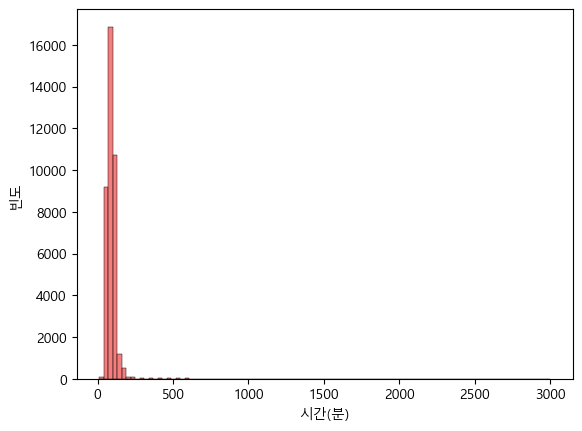

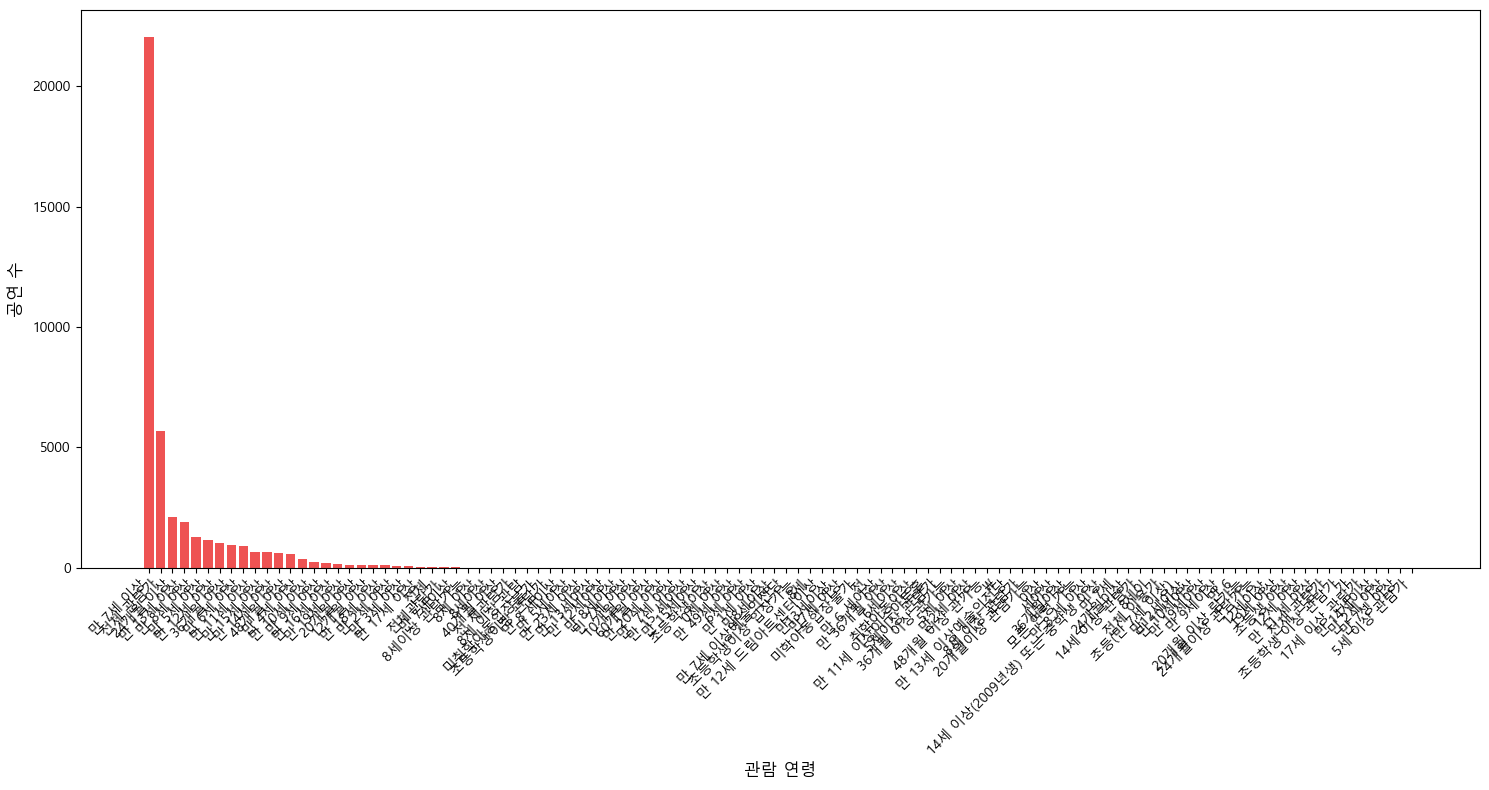

In [ ]:
# 그래프 글꼴 설정
plt.rc('font', family='Malgun Gothic')

# 1. 소요시간 분포 시각화

df_visualization = pd.read_excel(ML_DF_RAW_PATH)[['장르명','세부장르명','소요시간','관람연령']]

# 소요시간을 분 단위로 파싱한 임시 컬럼 생성
time_string_series = df_visualization['소요시간'].astype(str)
extracted_hours = time_string_series.str.extract(r'(\d+)\s*시간').astype(float).fillna(0)
extracted_minutes = time_string_series.str.extract(r'(\d+)\s*분').astype(float).fillna(0)
duration_minutes_series = (extracted_hours[0] * 60 + extracted_minutes[0])
duration_numeric_series = pd.to_numeric(time_string_series, errors='coerce')
df_visualization['소요시간(분)_EDA'] = duration_minutes_series.where(duration_minutes_series > 0, duration_numeric_series)

# 소요시간 분포 히스토그램
sns.histplot(df_visualization['소요시간(분)_EDA'].dropna(), bins=100, kde=False, color='#EE5353')
plt.xlabel('시간(분)')
plt.ylabel('빈도')
plt.show()

# 2. 관람연령 분포 시각화

# 관람연령 분포 막대그래프 (NaN 제외)
age_counts = df_visualization['관람연령'].value_counts(dropna=False)
age_counts_filtered = {k: v for k, v in age_counts.items() if not (isinstance(k, float) and pd.isna(k))}
plt.figure(figsize=(15, 8))
plt.bar(list(age_counts_filtered.keys()), list(age_counts_filtered.values()), color='#EE5353')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('관람 연령', fontsize=12)
plt.ylabel('공연 수', fontsize=12)
plt.tight_layout()
plt.show()

# 보조 컬럼 정리
df_visualization.drop(columns=['소요시간(분)_EDA'], inplace=True)
del df_visualization, time_string_series, extracted_hours, extracted_minutes, duration_minutes_series, duration_numeric_series, age_counts, age_counts_filtered


In [ ]:
def process_running_time(df: pd.DataFrame) -> pd.DataFrame:
    """'소요시간'을 정제, 결측치 처리, 범주화"""
    
    # 1. 문자열 -> 분(숫자) 변환
    series_str = df['소요시간'].astype(str)
    hours = series_str.str.extract(r'(\d+)\s*시간').astype(float).fillna(0)
    minutes = series_str.str.extract(r'(\d+)\s*분').astype(float).fillna(0)
    total_minutes = (hours[0] * 60 + minutes[0])
    plain_numbers = pd.to_numeric(series_str, errors='coerce')
    df['소요시간(단위 : 분)'] = total_minutes.where(total_minutes > 0, plain_numbers)
    
    # 2. 결측치(NaN)를 장르/세부장르별 최빈값으로 채우기
    mode_map = df.groupby(['장르명', '세부장르명'])['소요시간(단위 : 분)'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    df['소요시간(단위 : 분)'] = df['소요시간(단위 : 분)'].fillna(mode_map)

    # 3. 분 -> 범주로 변환
    bins = [-1, 60, 120, 180, np.inf]
    labels = ["1시간 이하", "1시간 이상 2시간 이하", "2시간 이상 3시간 이하", "3시간 이상"]
    df['소요시간'] = pd.cut(df['소요시간(단위 : 분)'], bins=bins, labels=labels)
    df.drop(columns=['소요시간(단위 : 분)'], inplace=True)
    return df

def process_age_rating(df: pd.DataFrame) -> pd.DataFrame:
    """'관람연령'을 정제, 결측치 처리, 범주화(외부 파일 미사용)"""

    # 1. 결측치(NaN)를 장르/세부장르별 최빈값으로 채우기
    mode_age = df.groupby(['장르명', '세부장르명'])['관람연령'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    df['관람연령'] = df['관람연령'].fillna(mode_age)
    df.dropna(subset=['관람연령'], inplace=True) 

    # 2. 관람연령 -> 범주로 변환
    age_series = df['관람연령'].astype(str)
    conditions = [
        age_series.isin(['전체 관람가', '0세 이상']),
        age_series.str.contains('개월|1세|2세|3세|4세|5세|6세|7세|8세 미만', na=False),
        age_series.str.contains('8세|9세|10세|11세|12세', na=False),
        age_series.str.contains('13세|14세|15세|16세|17세|18세|19세', na=False)
    ]
    choices = ['전체 관람가', '유아 관람 기준', '어린이 관람 기준', '청소년 관람 기준']
    df['관람연령기준'] = np.select(conditions, choices, default='성인 관람 기준')
    df.drop(columns=['관람연령'], inplace=True)
    return df

- 소요시간 처리 시작...
- 관람연령 처리 시작...
- 최종 피처 엔지니어링...

🎉 모든 전처리 완료. 최종 파일 저장: '../data/02_Data_Preprocessing/df_3차_전처리_후/machine_learning_final.xlsx'


In [ ]:
def main():
    """메인 실행 함수"""
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # --- 데이터 로드 및 초기 컬럼 선택 ---
    try:
        df_ml = pd.read_excel(ML_DF_RAW_PATH)
    except FileNotFoundError:
        print(f"경고: '{ML_DF_RAW_PATH}' 파일이 없어 3차 전처리를 건너뜁니다.")
        return

    desired_cols = ['장애인 시설 점수', '편의 시설 점수', '총 관객 수', '관람객 성비', '공연회차', '소요시간', '장르명',
                    '세부장르명', '관람연령', '아동공연 여부', '수상실적', '공연시설코드', '시설특성', '주소', '공연지역명', '좌석수']
    existing_cols = [c for c in desired_cols if c in df_ml.columns]
    missing = sorted(set(desired_cols) - set(existing_cols))
    if missing:
        print(f"참고: 다음 컬럼이 없어 제외됨 -> {missing}")
    df_ml = df_ml[existing_cols].copy()

    # --- 단계별 전처리 함수 호출 ---
    if {'총 관객 수','공연회차'}.issubset(df_ml.columns):
        df_ml = average_audience_per_show(df_ml)
    else:
        print("참고: '총 관객 수' 또는 '공연회차' 부재로 평균 관객 수 생성 생략")

    if '좌석수' in df_ml.columns and '공연시설코드' in df_ml.columns:
        df_ml = correct_seat_counts(df_ml, HALL_LIST_PATH)
    else:
        print("참고: 좌석/시설코드 컬럼 부재로 좌석 보정 생략")

    if '주소' in df_ml.columns:
        df_ml = standardize_addresses(df_ml)

    if '관람객 성비' in df_ml.columns:
        df_ml = transform_features(df_ml)

    if '소요시간' in df_ml.columns:
        df_ml = process_running_time(df_ml)

    if '관람연령' in df_ml.columns:
        df_ml = process_age_rating(df_ml)
    
    # --- 최종 피처 엔지니어링 ---
    if {'회차당 평균 관객 수','좌석수'}.issubset(df_ml.columns):
        df_ml['좌석 수 대비 관객 수'] = np.divide(df_ml['회차당 평균 관객 수'], df_ml['좌석수']).fillna(0)

    # --- 최종 정리 및 저장 ---
    if 'Unnamed: 0' in df_ml.columns:
        df_ml.set_index('Unnamed: 0', inplace=True)
    output_path = os.path.join(OUTPUT_DIR, FINAL_FILENAME)
    df_ml.to_excel(output_path, index=True)

if __name__ == "__main__":
    main()

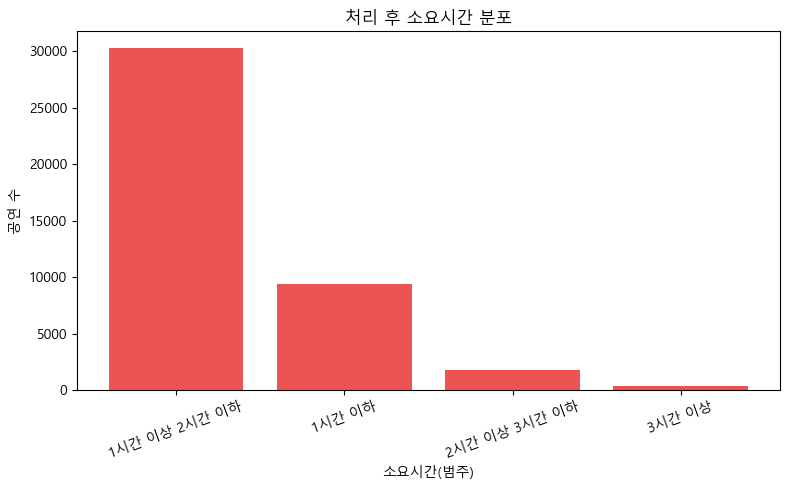

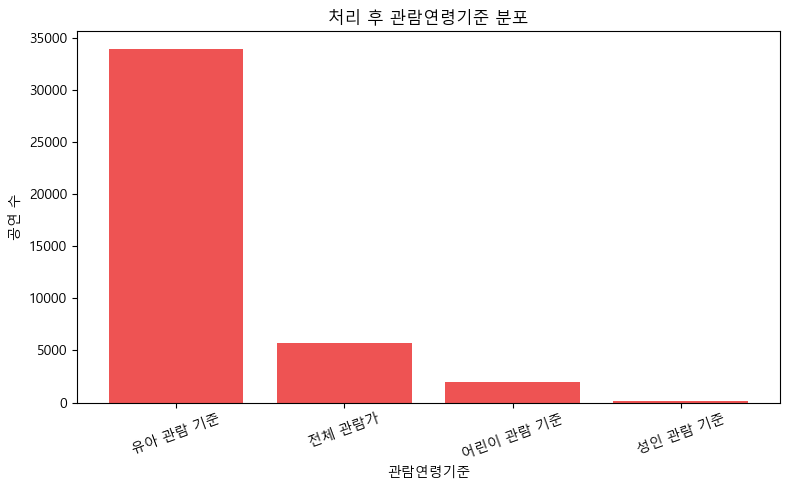

In [ ]:
plt.rc('font', family='Malgun Gothic')

# 전처리 3차 확인용 시각화: 처리 후 분포
final_path = os.path.join(OUTPUT_DIR, FINAL_FILENAME)

if not os.path.exists(final_path):
    print(f"참고: '{final_path}' 파일이 없어 시각화를 건너뜁니다.")
else:
    df_ml_final = pd.read_excel(final_path)

    if '소요시간' in df_ml_final.columns:
        plt.figure(figsize=(8, 5))
        time_counts = df_ml_final['소요시간'].value_counts()
        plt.bar(time_counts.index.astype(str), time_counts.values, color='#EE5353')
        plt.xlabel('소요시간(범주)')
        plt.ylabel('공연 수')
        plt.xticks(rotation=20)
        plt.title('처리 후 소요시간 분포')
        plt.tight_layout()
        plt.show()

    if '관람연령기준' in df_ml_final.columns:
        plt.figure(figsize=(8, 5))
        age_class_counts = df_ml_final['관람연령기준'].value_counts()
        plt.bar(age_class_counts.index.astype(str), age_class_counts.values, color='#EE5353')
        plt.xlabel('관람연령기준')
        plt.ylabel('공연 수')
        plt.xticks(rotation=20)
        plt.title('처리 후 관람연령기준 분포')
        plt.tight_layout()
        plt.show()


# 공연장 리스트 생성 (전처리 4차)


In [ ]:
# 입력 파일 경로 설정
KOPIS_YEARS_PATHS = [
    'data/01_Problem_Definition/kopis_19.xlsx',
    'data/01_Problem_Definition/kopis_20.xlsx',
    'data/01_Problem_Definition/kopis_21.xlsx',
    'data/01_Problem_Definition/kopis_22.xlsx',
]
HALL_DB_XLS = 'data/02_Data_Preprocessing/DB검색_공연시설DB.xls'
HALL_DATA_CSV = 'data/01_Problem_Definition/KC_486_WNTY_KOPIS_PRFPLC_2022.csv'
HALL_COLS_XLS = 'data/01_Problem_Definition/전국 KOPIS 공연시설 데이터(시군_컬럼정의서.xls'
SEAT_FIX_XLS = 'data/02_Data_Preprocessing/좌석수_정리.xlsx'

# 19~22년 KOPIS 공연 데이터 로드 및 결합
kopis_years = [pd.read_excel(p) for p in KOPIS_YEARS_PATHS]
kopis_all = pd.concat(kopis_years, axis=0, ignore_index=False)

# 최신 공연장 주소/코드 기준 데이터프레임 생성 (연도 통합 후 최신 공연장별 1행)
kopis_all['공연일시'] = pd.to_datetime(kopis_all['공연일시'])
kopis_sorted = kopis_all.sort_values(by='공연일시', ascending=False)
kopis_hall = kopis_sorted.drop_duplicates(subset=['공연장코드'], keep='first').copy()

# KOPIS 사이트 공연시설DB 로드/정리
hall_all = pd.read_excel(HALL_DB_XLS)

hall_df = hall_all.drop([0, 1, 3])
hall_df.columns = hall_df.iloc[0]
hall_df = hall_df.iloc[1:].copy()
hall_df = hall_df.rename(columns={hall_df.columns[9]: '구(군)'})
hall_df.drop(columns=['No.'], inplace=True)

hall_df['공연장명'] = hall_df['공연장명'].str.split('\n')
hall_df['객석수'] = hall_df['객석수'].str.split('\n')
hall_df = hall_df.explode(['공연장명', '객석수']).reset_index(drop=True)

# 주소 정제 재사용
hall_df['address_cleaned'] = clean_address_logic(hall_df['주소'])
hall_df.drop(columns=['주소'], inplace=True, errors='ignore')

# 시/도, 구(군) 파생 및 타입 정리
hall_df['시/도'] = hall_df['address_cleaned'].str.split().str[0]
hall_df['구(군)'] = hall_df['address_cleaned'].str.split().str[1]
hall_df = hall_df[~hall_df['시/도'].isin(['-', '태국'])].copy()
hall_df['객석수'] = pd.to_numeric(hall_df['객석수'].astype(str).str.replace(',', ''), errors='coerce')
hall_df['개관연도'] = pd.to_numeric(hall_df['개관연도'], errors='coerce')

# 한국문화정보원 공연시설 목록 로드/컬럼 정리
hall_data = pd.read_csv(HALL_DATA_CSV)
hall_cols = pd.read_excel(HALL_COLS_XLS)['컬럼한글명']
hall_data.columns = hall_cols

hall_data['address_cleaned'] = clean_address_logic(hall_data['도로명주소명'])
hall_data = hall_data[['시설명','address_cleaned','전화번호','홈페이지주소','개관년도']]
hall_data = hall_data.rename(columns={'시설명':'공연시설명','개관년도':'개관연도'})

# kopis_hall 주소 정제/표준화
kopis_hall['address_cleaned'] = clean_address_logic(kopis_hall['주소'])
kopis_hall['시/도'] = kopis_hall['address_cleaned'].str.split().str[0]
kopis_hall['구(군)'] = kopis_hall['address_cleaned'].str.split().str[1]
kopis_hall['객석수'] = pd.to_numeric(kopis_hall['좌석수'], errors='coerce')
kopis_hall['개관연도'] = pd.to_numeric(kopis_hall['개관연도'], errors='coerce')

# 주소 기준 교집합/차집합 계산
no_kopis = hall_df[~hall_df.set_index('address_cleaned').index.isin(kopis_hall.set_index('address_cleaned').index)]
no_hall = kopis_hall[~kopis_hall.set_index('address_cleaned').index.isin(hall_df.set_index('address_cleaned').index)]

hall_no_kopis = hall_df[hall_df['address_cleaned'].isin(hall_df['address_cleaned'].value_counts()[lambda s: s==1].index)]
kopis_no_hall = kopis_hall[kopis_hall['address_cleaned'].isin(kopis_hall['address_cleaned'].value_counts()[lambda s: s==1].index)]

# 주소가 중복되는 데이터 분리
hall_add_dup = hall_df[~hall_df['address_cleaned'].isin(hall_no_kopis['address_cleaned'])].copy()
kopis_add_dup = kopis_hall[~kopis_hall['address_cleaned'].isin(kopis_no_hall['address_cleaned'])].copy()

# 같은 주소/서로 다른 객석수 케이스 매칭
seat_no_dup = pd.merge(
    kopis_add_dup[['address_cleaned','객석수']],
    hall_add_dup[['address_cleaned','객석수']],
    on=['address_cleaned','객석수'], how='inner'
)

# 좌석수 정리 파일로 최대 관객수 보강
seat_fix = pd.read_excel(SEAT_FIX_XLS)
seat_fix = seat_fix.rename(columns={'Unnamed: 0':'공연코드','좌석수':'관객수'})
# kopis 원본에서 공연코드-주소 고유쌍 생성 후 관객수 결합
kopis_unique = kopis_all.drop_duplicates(subset='공연코드')[['공연코드','주소']]
max_seat = pd.merge(kopis_unique, seat_fix, on='공연코드', how='left')
kopis_all = pd.merge(kopis_all, max_seat, on=['공연코드','주소'], how='left')
# 공연시설-공연장 기준 최대 관객수
max_audience = kopis_all.groupby(['공연시설코드','공연장코드'])['관객수'].max().reset_index()

# hall_list 기본 프레임 구성(핵심 속성 중심)
lhs_cols = ['시설명','address_cleaned','시/도','구(군)','개관연도','시설특성','객석수']
left_part = hall_df[[c for c in lhs_cols if c in hall_df.columns]].rename(columns={'시설명':'공연시설명'})

rhs_cols_target = ['공연시설코드','공연장코드','공연장명','address_cleaned','시/도','구(군)','개관연도','시설특성','객석수']
rhs_cols = [c for c in rhs_cols_target if c in kopis_hall.columns]
right_part = kopis_hall[rhs_cols]

hall_list = pd.concat([left_part, right_part], axis=0, ignore_index=True)

# 전화/홈페이지 결합
hall_list = pd.merge(hall_list, hall_data, on=['address_cleaned'], how='left')

# 좌석/관객/수용가능인원 산출
hall_list['seat'] = hall_list['객석수']
hall_list = pd.merge(hall_list, max_audience, on=['공연시설코드','공연장코드'], how='left')
hall_list['수용가능인원'] = hall_list[['seat','관객수']].max(axis=1)

# 편의시설/장애인시설/무대시설 텍스트 구성
facility_cols = ['편의시설_레스토랑 여부','편의시설_카페 여부','편의시설_편의점 여부','편의시설_놀이방 여부','편의시설_수유실 여부']
obstacle_cols = ['장애인시설_주차장 여부','장애인시설_화장실 여부','장애인시설_경사로 여부','장애인시설_전용엘리베이터 여부']
stage_cols = ['무대시설_오케스트라피트 여부','무대시설_연습실 여부','무대시설_분장실 여부']

for col in facility_cols + obstacle_cols + stage_cols:
    if col in hall_list.columns:
        hall_list[col] = hall_list[col].apply(lambda x: np.nan if pd.isna(x) or x=='N' else col.split('_')[1])

hall_list['편의시설'] = hall_list[facility_cols].apply(lambda r: ', '.join([c for c in r if pd.notna(c)]), axis=1)
hall_list['장애인시설'] = hall_list[obstacle_cols].apply(lambda r: ', '.join([c for c in r if pd.notna(c)]), axis=1)
hall_list['무대시설'] = hall_list[stage_cols].apply(lambda r: ', '.join([c for c in r if pd.notna(c)]), axis=1)

# 주차시설 상태 파생
if {'주차시설_자체 여부','주차시설_공영 여부'}.issubset(hall_list.columns):
    def set_parking_status(row):
        if row['주차시설_자체 여부'] == 'N' and row['주차시설_공영 여부'] == 'N':
            return '주차시설 없음'
        elif row['주차시설_자체 여부'] == 'N' and row['주차시설_공영 여부'] == 'Y':
            return '근처 공영주차장 있음'
        elif row['주차시설_자체 여부'] == 'Y' and row['주차시설_공영 여부'] == 'Y':
            return '자체 주차장 및 근처 공영 주차장 있음'
        elif row['주차시설_자체 여부'] == 'Y' and row['주차시설_공영 여부'] == 'N':
            return '자체 주차장 있음'
        else:
            return '기타'
    hall_list['주차시설'] = hall_list.apply(set_parking_status, axis=1)

# 장르(시설/공연장 기준 고유 조합 텍스트) 생성
kopis_genre_concat = kopis_all.groupby(['공연시설코드','공연장코드']).agg({
    '세부장르명': lambda x: ', '.join(pd.Series(x).drop_duplicates()),
    '장르명': lambda x: ', '.join(pd.Series(x).drop_duplicates())
}).reset_index()

hall_list = pd.merge(hall_list, kopis_genre_concat, on=['공연시설코드','공연장코드'], how='left')

# 공연장수 산출(시설별 고유 공연장코드 수)
if {'공연시설코드','공연장코드'}.issubset(kopis_all.columns):
    facility_hall_counts = kopis_all.groupby('공연시설코드')['공연장코드'].nunique().reset_index().rename(columns={'공연장코드':'공연장수'})
    hall_list = pd.merge(hall_list, facility_hall_counts, on='공연시설코드', how='left')

# 정리 및 저장 (존재하는 컬럼만 선택)
selected_cols = ['공연시설명','공연시설코드','공연장수','공연장명','공연장코드','seat','관객수','수용가능인원',
                 'address_cleaned','시/도','구(군)','개관연도','시설특성','무대시설_무대넓이',
                 '세부장르명','장르명','편의시설','장애인시설','무대시설','전화번호','홈페이지주소']
hall_list = hall_list[[c for c in selected_cols if c in hall_list.columns]]

# 숫자형 정리
for col in ['seat','관객수','수용가능인원','개관연도','공연장수']:
    if col in hall_list.columns:
        hall_list[col] = pd.to_numeric(hall_list[col], errors='coerce')

# 파일 저장
HALL_LIST_OUTPUT = 'data/df_공연장목록/공연장 목록 생성 파일/hall_list.xlsx'
os.makedirs(os.path.dirname(HALL_LIST_OUTPUT), exist_ok=True)
hall_list.to_excel(HALL_LIST_OUTPUT, index=False)